In [1]:
import os
import numpy as np

import spyglass as nd
import datajoint as dj
import multiprocessing
import spyglass.data_import as sdi

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
warnings.simplefilter('ignore', category=UserWarning)

import matplotlib.pyplot as plt

[2023-10-05 09:30:52,539][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-10-05 09:30:52,565][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)

In [3]:
from spyglass.common import Session

In [18]:
# We also import a bunch of tables so that we can call them easily
from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  PositionSource,
                                  FirFilter,
                                  IntervalList, 
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery) #SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, 
                                  #SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting, AutomaticCurationSpikeSortingParameters,SortInterval,

ImportError: cannot import name 'HeadDir' from 'spyglass.common' (/home/shijiegu/Documents/spyglass/src/spyglass/common/__init__.py)

In [4]:
from pathlib import Path
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
os.environ['SPYGLASS_BASE_DIR'] = "/stelmo/nwb/"
os.environ['SPYGLASS_RECORDING_DIR'] = "/stelmo/nwb/recording"
os.environ['SPYGLASS_SORTING_DIR'] = "/stelmo/nwb/sorting"
os.environ['SPYGLASS_WAVEFORMS_DIR'] = "/stelmo/nwb/waveforms"
os.environ['SPYGLASS_TEMP_DIR'] = "/stelmo/nwb/tmp"
os.environ['KACHERY_DAEMON_HOST'] = "typhoon"
os.environ['KACHERY_DAEMON_PORT'] = "14747"
os.environ['KACHERY_STORAGE_DIR'] = "/stelmo/nwb/kachery-storage"
os.environ['KACHERY_TEMP_DIR'] = "/stelmo/nwb/tmp"
os.environ['FIGURL_CHANNEL'] = "franklab2"
os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = "TRUE"
dj.config["enable_python_native_blobs"] = True

In [5]:
dj.config["stores"]['raw']['location']='/stelmo/nwb/raw'
dj.config["stores"]['raw']['stage']='/stelmo/nwb/raw'
dj.config["stores"]['analysis']['location']='/stelmo/nwb/analysis'
dj.config["stores"]['analysis']['stage']='/stelmo/nwb/analysis'

In [6]:
dj.config

{   'connection.charset': '',
    'connection.init_function': None,
    'database.host': 'lmf-db.cin.ucsf.edu',
    'database.password': '1234',
    'database.port': 3306,
    'database.reconnect': True,
    'database.use_tls': True,
    'database.user': 'shijiegu',
    'display.limit': 12,
    'display.show_tuple_count': True,
    'display.width': 14,
    'enable_python_native_blobs': True,
    'fetch_format': 'array',
    'filepath_checksum_size_limit': None,
    'loglevel': 'INFO',
    'safemode': True,
    'stores': {   'analysis': {   'location': '/stelmo/nwb/analysis',
                                  'protocol': 'file',
                                  'stage': '/stelmo/nwb/analysis'},
                  'raw': {   'location': '/stelmo/nwb/raw',
                             'protocol': 'file',
                             'stage': '/stelmo/nwb/raw'}}}

In [9]:
Session&{"experiment_description":'Four-Arm Sequence'}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
eliot20221014_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221014,Seq2,2022-10-14 10:18:19,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221016_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221016,Seq2,2022-10-16 10:52:56,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221017_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221017,Seq2,2022-10-17 10:03:16,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221018_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221018,Seq2,2022-10-18 11:39:50,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221019_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221019,Seq2,2022-10-19 09:17:58,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221020_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221020,Seq2,2022-10-20 08:40:50,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221021_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221021,Seq2,2022-10-21 12:36:50,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221022_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221022,Seq2,2022-10-22 10:28:14,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221023_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221023,Seq2,2022-10-23 11:21:02,1970-01-01 00:00:00,Four-Arm Sequence
eliot20221024_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221024,Seq2,2022-10-24 10:31:57,1970-01-01 00:00:00,Four-Arm Sequence


In [13]:
'''
(nd.common.Raw & {'nwb_file_name':'molly20220419_.nwb'}).delete()
(nd.common.Session & {'nwb_file_name':'molly20220419_.nwb'}).delete()
(nd.common.Nwbfile & {'nwb_file_name':'molly20220419_.nwb'}).delete()

Deleting 1 rows from `common_ephys`.`_raw`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 11 rows from `common_behav`.`_raw_position`
Deleting 11 rows from `common_behav`.`position_source`
Deleting 17 rows from `common_dio`.`_d_i_o_events`
Deleting 256 rows from `common_ephys`.`_electrode`
Deleting 64 rows from `common_ephys`.`_electrode_group`
Deleting 11 rows from `common_behav`.`_state_script_file`
Deleting 11 rows from `common_behav`.`_video_file`
Deleting 11 rows from `common_task`.`_task_epoch`
Deleting 1 rows from `common_sensors`.`_sensor_data`
Deleting 23 rows from `common_interval`.`interval_list`
Deleting 1 rows from `common_session`.`_experimenter_list__experimenter`
Deleting 1 rows from `common_session`.`_experimenter_list`
Deleting 1 rows from `common_session`.`_session`


Commit deletes? [yes, No]:  yes


Deletes committed.
Deleting 1 rows from `common_nwbfile`.`nwbfile`


Commit deletes? [yes, No]:  yes


Deletes committed.


1

In [14]:
(nd.common.Session & {'nwb_file_name':'molly20220419_.nwb'})

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


In [15]:
nd.common.Nwbfile().cleanup(delete_files=True)

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.05s/it]


In [16]:
!ls $SPYGLASS_BASE_DIR/raw/molly*

/stelmo/nwb//raw/molly20220415.nwb   /stelmo/nwb//raw/molly20220417_.nwb
/stelmo/nwb//raw/molly20220415_.nwb  /stelmo/nwb//raw/molly20220418.nwb
/stelmo/nwb//raw/molly20220416.nwb   /stelmo/nwb//raw/molly20220419.nwb
/stelmo/nwb//raw/molly20220416_.nwb  /stelmo/nwb//raw/molly20220420.nwb
/stelmo/nwb//raw/molly20220417.nwb   /stelmo/nwb//raw/molly20220420_.nwb


## Add data to database

In [7]:
sdi.insert_sessions('eliot20221027.nwb')

In [11]:
from spyglass.common.common_interval import IntervalList
Session & {'nwb_file_name':'eliot20221027_.nwb'}
IntervalList & {'nwb_file_name':'eliot20221027_.nwb'}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
eliot20221027_.nwb,01_Seq2Sleep1,=BLOB=
eliot20221027_.nwb,02_Seq2Session1,=BLOB=
eliot20221027_.nwb,03_Seq2Sleep2,=BLOB=
eliot20221027_.nwb,04_Seq2Session2,=BLOB=
eliot20221027_.nwb,05_Seq2Sleep3,=BLOB=
eliot20221027_.nwb,06_Seq2Session3,=BLOB=
eliot20221027_.nwb,07_Seq2Sleep4,=BLOB=
eliot20221027_.nwb,08_Seq1Session4,=BLOB=
eliot20221027_.nwb,09_Seq1Sleep5,=BLOB=
eliot20221027_.nwb,10_Seq1Session5,=BLOB=


In [8]:
dates=['20220418','20220419']

In [17]:
%%capture stored_output
nd.insert_sessions('molly20220418.nwb')
nd.insert_sessions('molly20220419.nwb')

In [9]:
%%capture stored_output
with multiprocessing.Pool(2) as p:
    p.map(nd.insert_sessions,['molly'+s+'.nwb' for s in dates])

In [12]:
stored_output.show()

Creating a copy of NWB file isaac20230519.nwb with link to raw ephys data: isaac20230519_.nwb
Populate Session...
No config found at file path /stelmo/nwb/raw/isaac20230519_spyglass_config.yaml
Institution...
Lab...
LabMember...
Subject...
Populate DataAcquisitionDevice...
Inserted or referenced data acquisition device(s): dict_keys(['dataacq_device0'])

Populate CameraDevice...
Inserted camera devices ['sleep_camera', 'maze_camera']

Populate Probe...
Probe ID 'tetrode_12.5' already exists in the database. Spyglass will use that and not create a new Probe, Shanks, or Electrodes.
Inserted probes {'tetrode_12.5'}

Skipping Apparatus for now...
IntervalList...
Populate ElectrodeGroup...
Populate Electrode...
No config found at file path /stelmo/nwb/raw/isaac20230519_spyglass_config.yaml
Populate Raw...
Estimating sampling rate...
Estimated sampling rate: 30000.0
Importing raw data: Sampling rate:	30000.0 Hz
Number of valid intervals:	3
Populate SampleCount...
Populate DIOEvents...
Popula

In [40]:
# Define the name of the file that you copied and renamed; make sure it's something unique. 
nwb_file_name = 'molly20220415.nwb'
filename, file_extension = os.path.splitext(nwb_file_name)
# This is a copy of the original nwb file, except it doesn't contain the raw data (for storage reasons)
nwb_file_name2 = filename + '_' + file_extension

nd.insert_sessions(nwb_file_name)

Creating a copy of NWB file molly20220415.nwb with link to raw ephys data: molly20220415_.nwb
Populate Session...
Institution...
Lab...
LabMember...
Please add the Google user ID for Shijie Gu in the LabMember.LabMemberInfo table if you want to give them permission to manually curate sortings by this team.
Subject...
DataAcquisitionDevice...
Inserted data acquisition devices ['dataacq_device0']
CameraDevice...
Inserted camera devices ['sleep_camera', 'maze_camera']
Probe...
No conforming probe device metadata found.
Skipping Apparatus for now...
IntervalList...
Populate ExperimenterList...
Populate ElectrodeGroup...
Populate Electrode...
Populate Raw...
Estimating sampling rate...
Estimated sampling rate: 30000.0
Importing raw data: Estimated sampling rate:	30000.0 Hz
Number of valid intervals:	10
Populate SampleCount...
Populate DIOEvents...
Populate SensorData
Populate TaskEpochs
Populate StateScriptFile
Populate VideoFile
RawPosition...
Processing raw position data. Estimated sampli

In [94]:
#%debug

In [12]:
Session & {'nwb_file_name':'eliot20221014_.nwb'}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
eliot20221014_.nwb,eliot,"University of California, San Francisco",Loren Frank,eliot_20221014,Seq2,2022-10-14 10:18:19,1970-01-01 00:00:00,Four-Arm Sequence


In [101]:
nwb_file_name2='molly20220420_.nwb'

In [102]:
rawdata = Raw().nwb_object({'nwb_file_name':nwb_file_name2})

In [103]:
rawdata.data.shape

(865608585, 256)

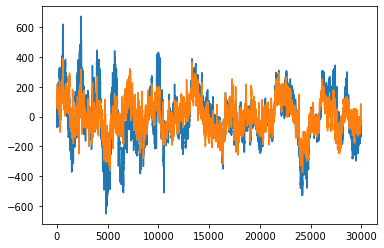

In [104]:
plt.plot(rawdata.data[1:30000,15])
plt.plot(rawdata.data[1:30000,16*4+1])

In [58]:
Raw & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
molly20220415_.nwb,raw data valid times,6d418841-e640-4d7f-8490-b835c6335963,30000.0,No comment,Recording of extracellular voltage


In [6]:
import pynwb

In [32]:
io = pynwb.NWBHDF5IO('/stelmo/nwb/raw/molly20220419.nwb','r')
nwbf = io.read()

epochs = nwbf.epochs.to_dataframe()

rawdata = nwbf.get_acquisition()
timestamps=np.asarray(rawdata.timestamps)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "


In [55]:
posdata=nwbf.processing['behavior']['position']['series_1'].data

series_1 pynwb.behavior.SpatialSeries at 0x140641282295408
Fields:
  comments: no comments
  conversion: 0.0025
  data: <HDF5 dataset "data": shape (49114, 4), type "<i2">
  description: xloc, yloc, xloc2, yloc2
  interval: 1
  reference_frame: Upper left corner of video frame
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (49114,), type "<f8">
  timestamps_unit: seconds
  unit: meters

In [28]:
gyrodata=nwbf.processing['analog']['analog'].time_series['analog'].data

In [35]:
nwbf.processing['analog']['analog'].time_series['analog']

analog pynwb.base.TimeSeries at 0x140641282214304
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (679255959, 6), type "<i4">
  description: Headstage_GyroY   Headstage_AccelX   Headstage_GyroX   Headstage_AccelY   Headstage_AccelZ   timestamps   Headstage_GyroZ   
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (679255959,), type "<f8">
  timestamps_unit: seconds
  unit: unspecified

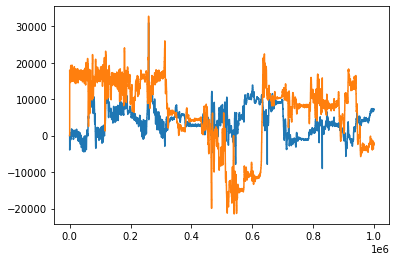

In [49]:

plt.plot(gyrodata[1:1000000,1])

plt.plot(gyrodata[1:1000000,3])

In [113]:
(IntervalList & {'nwb_file_name':nwb_file_name2})

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
molly20220420_.nwb,01_Seq2Sleep1,=BLOB=
molly20220420_.nwb,02_Seq2Session1,=BLOB=
molly20220420_.nwb,03_Seq2Sleep2,=BLOB=
molly20220420_.nwb,04_Seq2Session2,=BLOB=
molly20220420_.nwb,05_Seq2Sleep3,=BLOB=
molly20220420_.nwb,06_Seq2Session3,=BLOB=
molly20220420_.nwb,07_Seq2Sleep4,=BLOB=
molly20220420_.nwb,08_Seq2Session4,=BLOB=
molly20220420_.nwb,09_Seq2Sleep5,=BLOB=
molly20220420_.nwb,10_Seq2Session5,=BLOB=


In [115]:
interval_list_name=(IntervalList & {'nwb_file_name':nwb_file_name2}).fetch('interval_list_name')

In [121]:
session_time=[]
for i in range(13):
    session_time.append((IntervalList & {'nwb_file_name':nwb_file_name2,'interval_list_name':interval_list_name[i]}).fetch1('valid_times'))

In [119]:
session_time

[array([[1.65047092e+09, 1.65047273e+09]]),
 array([[1.65047277e+09, 1.65047496e+09]]),
 array([[1.65047508e+09, 1.65047739e+09]]),
 array([[1.65047745e+09, 1.65047969e+09]]),
 array([[1.65047983e+09, 1.65048165e+09]]),
 array([[1.6504817e+09, 1.6504840e+09]]),
 array([[1.65048420e+09, 1.65048607e+09]]),
 array([[1.65048626e+09, 1.65048863e+09]]),
 array([[1.65048909e+09, 1.65049150e+09]]),
 array([[1.65049173e+09, 1.65049430e+09]]),
 array([[1.65049442e+09, 1.65049718e+09]]),
 array([[1.65049748e+09, 1.65049983e+09]]),
 array([[1.65049990e+09, 1.65050174e+09]])]

In [111]:
Seq2Session2

array([[1.6504817e+09, 1.6504840e+09]])

In [86]:
Seq2Session2_pos=(IntervalList & {'nwb_file_name':nwb_file_name2,'interval_list_name':'pos 5 valid times'}).fetch1('valid_times')

In [106]:
valid_times=(IntervalList & {'nwb_file_name':nwb_file_name2,'interval_list_name':'raw data valid times'}).fetch1('valid_times')
valid_times

array([[1.65047092e+09, 1.65047158e+09],
       [1.65047158e+09, 1.65047158e+09],
       [1.65047158e+09, 1.65047158e+09],
       [1.65047158e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047162e+09],
       [1.65047162e+09, 1.65047176e+09],
       [1.65047176e+09, 1.65047176e+09],
       [1.65047176e+09, 1.65047176e+09],
       [1.65047176e+09, 1.65047176e+09],
       [1.65047176e+09, 1.65047176e+09],
       [1.65047176e+09, 1.65047273e+09],
       [1.65047277e+09, 1.65047496e+09],
       [1.65047508e+09, 1.65047739e+09],
       [1.65047745e+09, 1.65047969e+09],
       [1.65047983e+09, 1.65048165e+09],
       [1.65048170e+09, 1.65048400e+09],
       [1.65048420e+09, 1.65048607e+09],
       [1.650486

In [127]:
i=1
valid_times[i,0],valid_times[i,1]

(1650471577.9359105, 1650471577.9383771)

In [128]:
valid_times[i,1]-valid_times[i,0]

0.0024666786193847656

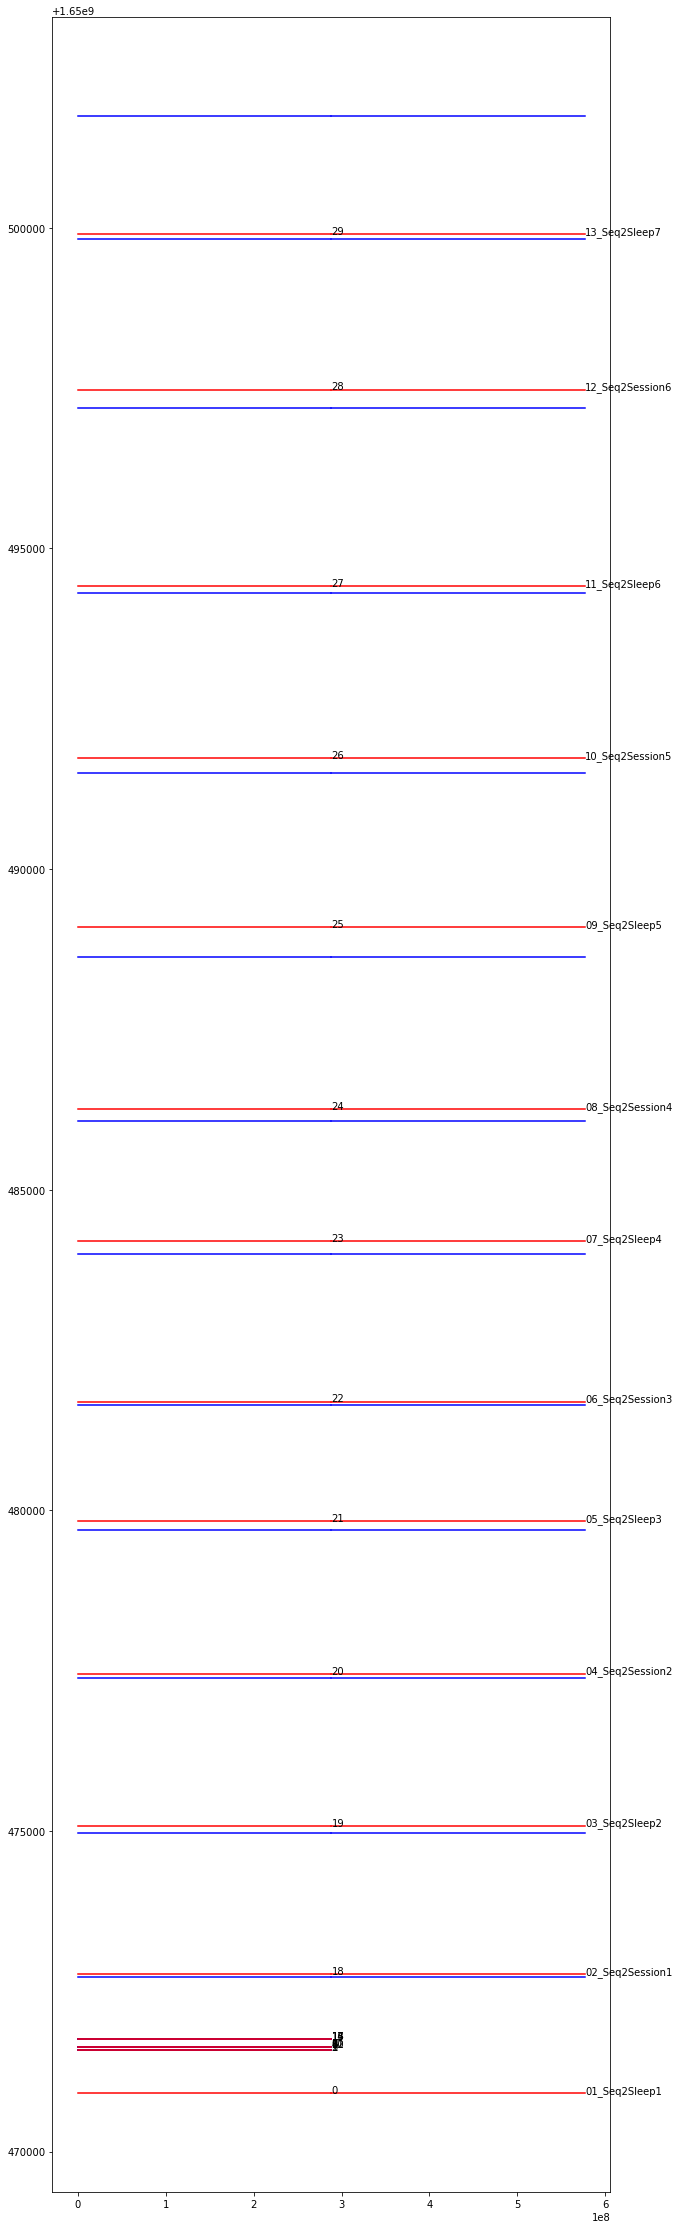

In [124]:

plt.figure(figsize=(10,40))
#plt.plot(timestamps)
filelength=len(timestamps)
for i in range(np.shape(valid_times)[0]):
    plt.plot([0,filelength/3],[valid_times[i,0],valid_times[i,0]],'r')
    plt.plot([0,filelength/3],[valid_times[i,1],valid_times[i,1]],'b')
    plt.text(round(filelength/3),valid_times[i,0],str(i))
    
    
for i in range(np.shape(session_time)[0]):
    plt.plot([filelength/3,2*filelength/3],[session_time[i][0,0],session_time[i][0,0]],'r')
    plt.plot([filelength/3,2*filelength/3],[session_time[i][0,1],session_time[i][0,1]],'b')
    plt.text(round(2*filelength/3),session_time[i][0,0],interval_list_name[i])


In [18]:
(IntervalList & {'nwb_file_name':nwb_file_name2, 'interval_list_name':'07_Seq2Sleep3'}).fetch1('valid_times')

array([[1.65005882e+09, 1.65006057e+09]])

## Make LFP

In [51]:
FirFilter().create_standard_filters()

In [70]:
electrode_ids = (Electrode & {'nwb_file_name' : nwb_file_name2}).fetch('electrode_id')
lfp_electrode_ids = electrode_ids
LFPSelection().set_lfp_electrodes(nwb_file_name2, lfp_electrode_ids.tolist())

Deleting 0 rows from `common_ephys`.`l_f_p_selection`
Nothing to delete.


In [ ]:
LFP().populate([LFPSelection & {'nwb_file_name':nwb_file_name2}])

LFP: found 10 of 10 intervals > 1.0 sec long.
Writing new NWB file molly20220416_JR1ZROCK77.nwb


IOStream.flush timed out


Filtering data
Interval 0: loading data into memory
Interval 1: loading data into memory
Interval 2: loading data into memory
Interval 3: leaving data on disk


In [ ]:
LFP&{'nwb_file_name':nwb_file_name2}